These are for eBOSS ELG all vtest catalogs. I used fracgood as additional feature, but excluding ndet. At the end we decided to remove that as feature. Use fracgood as weight in MSE (objective function). And the label as Ngal/Nran x Nrantot/Ngaltot

In [1]:
%matplotlib inline
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
files = glob('/global/cscratch1/sd/mehdi/eboss/ebossv5_10_7/march12/data4fold/wo-ndet/fold*/*')
files.sort()

In [285]:
"""
    Reading the Ngal and systematic
"""
p_true = []
x_true = []
y_true = []
y_pred = []
y_base = []
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    p_true.append(out['test'][0])
    x_true.append(out['test'][1])
    y_true.append(out['test'][2].squeeze())
    ybasei = np.ones(out['test'][2].shape[0])*np.mean(out['train'][2])
#     print(np.sqrt(np.mean((out['test'][2].squeeze() - ybasei)**2)), ybasei[0])
    y_base.append(ybasei)
    y_avg = []
    for i in range(len(out['chain_y'])):
        y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
    meanY, stdY = out['options']['stats']['ystat']
    print(meanY, stdY)
    y_pred.append(stdY*np.mean(np.array(y_avg), axis=0) + meanY)

Ptrue = np.concatenate(p_true)
Xtrue = np.concatenate(x_true)
Ytrue = np.concatenate(y_true)
Ybase = np.concatenate(y_base)
Ypred = np.concatenate(y_pred)
print(Xtrue.shape, Ytrue.shape, Ypred.shape, Ybase.shape)

[ 17.03329405] [ 5.92700879]
[ 16.97527459] [ 5.89793006]
[ 17.04470435] [ 5.92839911]
[ 17.03960534] [ 5.89585891]
(22357, 13) (22357,) (22357,) (22357,)


In [37]:
Xtrue.shape

(22357, 13)

In [5]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')

from syslss import ngalsys

In [286]:
npix = 12*256**2
mask = np.zeros(npix)
mask[Ptrue] = 1.0
ranmap2 = np.zeros(npix)
ranmap2[Ptrue] = Ypred
galmap = np.zeros(npix) 
galmap[Ptrue] = Ytrue 
ranmap1 = np.zeros(npix)
ranmap1[Ptrue] = Xtrue[:, 0] # fracgood

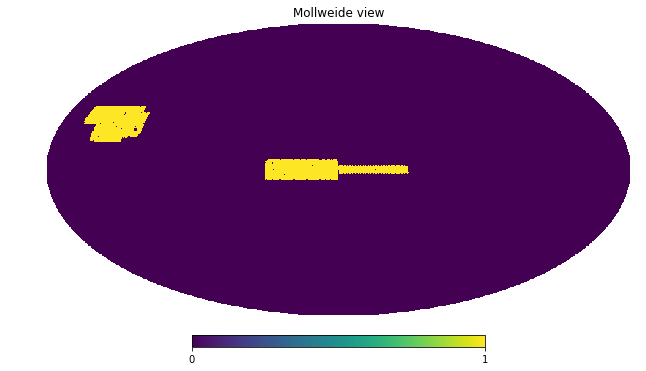

In [287]:
import healpy as hp
hp.mollview(mask)

In [288]:
class systematic(object):
    def __init__(self, sysname, mask):
        df = sysname #ft.read(sysname, lower=True)
        self.HPIX = np.argwhere(~np.logical_not(mask)).flatten()
        self.SIGNAL = df[~np.logical_not(mask)]

In [289]:
allchunks = dict()
for i in range(Xtrue.shape[1]):
    print(i)
    sysi  = np.zeros(npix)
    sysi[Ptrue]  = Xtrue[:,i]  # nstar
    sysi256 = systematic(sysi, mask)
    sysibin = np.linspace(Xtrue[:,i].min(), Xtrue[:,i].max(), 15)
    print(sysibin)
    #
    eboss = ngalsys(galmap, 256,hpmap=True)
    eboss.prepare_inputs(sysi256, selection_function=mask, fracdet_c=0.2)
    eboss.digitize_ngalsys(sysibin)
    eboss.processjack(njack=10)
    #
    ebossai = ngalsys(galmap, 256,hpmap=True)
    ebossai.prepare_inputs(sysi256, selection_function=ranmap2, fracdet_c=0.2)
    ebossai.digitize_ngalsys(sysibin)
    ebossai.processjack(njack=10)
    allchunks[i] = dict(uni = eboss.output, ai=ebossai.output)

0
[ 0.20042931  0.25786423  0.31529915  0.37273407  0.43016899  0.48760391
  0.54503883  0.60247375  0.65990867  0.7173436   0.77477852  0.83221344
  0.88964836  0.94708328  1.0045182 ]
1
[  847.14093018  1219.8182591   1592.49558803  1965.17291696  2337.85024588
  2710.52757481  3083.20490374  3455.88223267  3828.55956159  4201.23689052
  4573.91421945  4946.59154837  5319.2688773   5691.94620623  6064.62353516]
2
[  898.80950928  1292.97511074  1687.14071219  2081.30631365  2475.47191511
  2869.63751657  3263.80311802  3657.96871948  4052.13432094  4446.2999224
  4840.46552386  5234.63112531  5628.79672677  6022.96232823  6417.12792969]
3
[ 0.01188202  0.02494418  0.03800634  0.0510685   0.06413066  0.07719282
  0.09025498  0.10331713  0.11637929  0.12944145  0.14250361  0.15556577
  0.16862793  0.18169009  0.19475225]
4
[ 1.02190435  1.13805082  1.25419729  1.37034376  1.48649023  1.6026367
  1.71878317  1.83492965  1.95107612  2.06722259  2.18336906  2.29951553
  2.415662    2.5318

/global/homes/m/mehdi/github/DESILSS/syslss.py:331: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(std)/(len(self.sysl[i])-1.)


6
[ 0.81548214  0.90171836  0.98795458  1.0741908   1.16042703  1.24666325
  1.33289947  1.41913569  1.50537191  1.59160813  1.67784435  1.76408058
  1.8503168   1.93655302  2.02278924]
7
[   102.5774765    1127.60277394   2152.62807138   3177.65336881
   4202.67866625   5227.70396369   6252.72926113   7277.75455856
   8302.779856     9327.80515344  10352.83045088  11377.85574831
  12402.88104575  13427.90634319  14452.93164062]
8
[   33.21646118   623.95288304  1214.6893049   1805.42572675  2396.16214861
  2986.89857047  3577.63499233  4168.37141418  4759.10783604  5349.8442579
  5940.58067976  6531.31710161  7122.05352347  7712.78994533  8303.52636719]
9
[   9.9537468    75.31560162  140.67745645  206.03931127  271.4011661
  336.76302092  402.12487575  467.48673058  532.8485854   598.21044023
  663.57229505  728.93414988  794.2960047   859.65785953  925.01971436]
10
[   71.59520721   703.01621083  1334.43721444  1965.85821806  2597.27922167
  3228.70022529  3860.1212289   4491.542232

In [39]:
ls /global/cscratch1/sd/mehdi/eboss/ebossv5_10_7/march12/data4fold/wo-ndet/

diff_chunks.npy   eboss_dnstar_ai.npy  fold0/  fold2/
eboss_dnstar.npy  eboss_nnbar_all.npy  fold1/  fold3/


In [40]:
np.save('/global/cscratch1/sd/mehdi/eboss/ebossv5_10_7/march12/data4fold/wo-ndet/eboss_nnbar_all', allchunks)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12


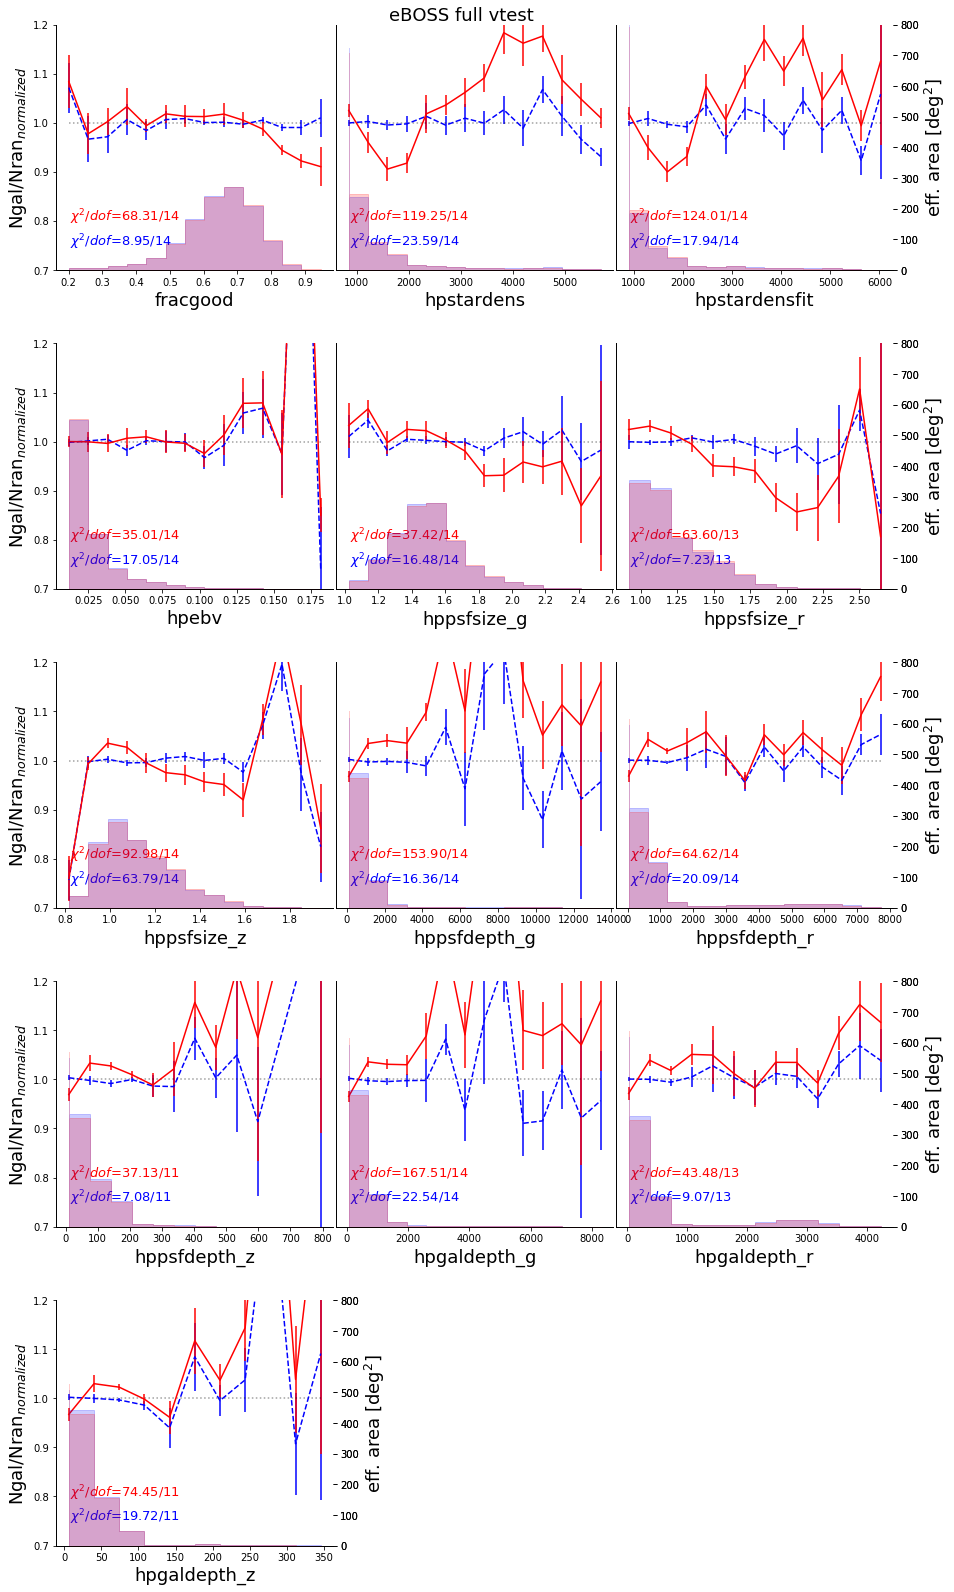

In [290]:
syscols = ['hpstardens', 'hpstardensfit', 'hpebv', 
           'hppsfsize_g', 'hppsfsize_r', 'hppsfsize_z', 
           'hppsfdepth_g', 'hppsfdepth_r', 'hppsfdepth_z', 
           'hpgaldepth_g', 'hpgaldepth_r', 'hpgaldepth_z']
labels = ['fracgood'] + syscols
plt.rc('axes.spines', top=False, right=False)
f,a = plt.subplots(ncols=3, nrows=5, figsize=(15, 25))
plt.suptitle("eBOSS full vtest", fontsize=18)
a = a.flatten()
plt.subplots_adjust(wspace=0.01, hspace=0.3, top=0.97)
f.delaxes(a[-1])
f.delaxes(a[-2])



def helper(name):
    x = name['bin_edges'][:-1]
    y = name['delta']
    ye = name['delta_err']
    s = name['area']
    mask = (y != 0.0 ) & ~np.isnan(y) & (ye !=0.0) & (~np.isnan(ye))
    x = x[mask]
    y = y[mask]
    ye = ye[mask]
    s  = s[mask]
    return x, y, ye, s

chi2 = lambda y, ye: np.sum(((y-1.0)/ye)**2)

def add_plot(ax, n, t, i, text=True, **kwargs):
    a2 = ax.twinx()
    x,y,ye,s = helper(n)
    ax.errorbar(x, y, yerr=ye,**kwargs)
    kwargs.pop('linestyle')
    ax.text(0.05, 0.1+0.1*i, r'$\chi^{}/dof$={:.2f}/{}'.format(2, chi2(y, ye),y.size),
           transform=ax.transAxes, **kwargs, fontsize=13)
    a2.fill_between(x, s, step='pre', alpha=0.2, **kwargs)
    a2.set_ylim(0,800)
    ax.set_ylim(0.7, 1.2)
    ax.plot([x.min(), x.max()], [1, 1], 'k:', alpha=0.2)
    return a2


for j,i in enumerate(range(0,13)):
    print(j,i)
    a2_0 = add_plot(a[j], allchunks[i]['ai'], labels[i], 0, color='b', linestyle='--')
    a2_1 = add_plot(a[j], allchunks[i]['uni'], labels[i],1, color='r', text=False, linestyle='-')
    if j in [0, 3, 6, 9, 12]:
        a[j].set_ylabel(r'Ngal/Nran$_{normalized}$', fontsize=18)
    else:
        a[j].set_yticks([])
    if j in [2, 5, 8, 11, 12]:
        a2_1.set_ylabel(r'eff. area [deg$^{2}$]', fontsize=18)
    else:
        a2_1.set_yticks([])
        a2_0.set_yticks([])
    a[j].set_xlabel(labels[i], fontsize=18)    

Fracgood is weird! so we decide to look into it. It is the 0th element of Xtrue.

In [59]:
from scipy.stats import binned_statistic

In [61]:
binned_statistic?

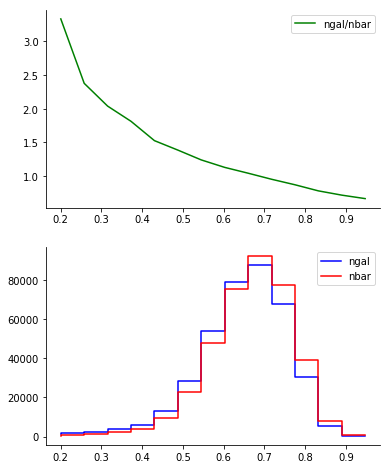

In [210]:
b = np.linspace(Xtrue[:,0].min(), Xtrue[:,0].max(), 15)
y1,_,_ = binned_statistic(Xtrue[:,0], values=Ytrue, bins=b, statistic='sum')       # sum of Ngal
yp,_,_ = binned_statistic(Xtrue[:,0], values=Ypred, bins=b, statistic='sum')       # sum of Npred
y2,_,_ = binned_statistic(Xtrue[:,0], values=Xtrue[:,0], bins=b, statistic='sum')  # sum of fracgood
sf = y2.sum()/y1.sum()
sf2 = y2.sum()/yp.sum()
plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(b[:-1], y1/y2*sf, 'g', label='ngal/nbar')
plt.legend()
# plt.plot(b[:-1], yp/y2*sf2, 'violet')
# plt.ylim(0.7,1.2)
plt.subplot(212)
plt.step(b[:-1], y1, 'b', label='ngal')
plt.step(b[:-1], y2/sf, 'r', label='nbar')
plt.legend()

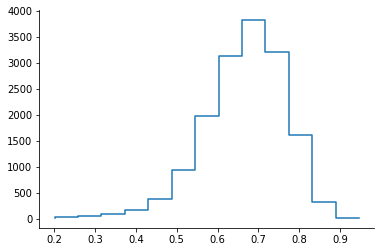

In [211]:
plt.step(b[:-1]*(10000/hp.nside2pixarea(256, degrees=True)), y2)

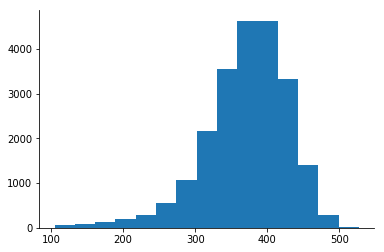

In [216]:
nran = Xtrue[:,0] * (10000*hp.nside2pixarea(256, degrees=True))
_=plt.hist(nran, bins=15)

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


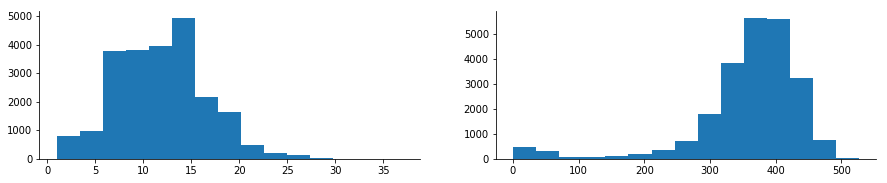

In [240]:
# check hmap
ranhp = hp.read_map('/global/cscratch1/sd/mehdi/eboss/ebossv5_10_7/march12/hp-ran256.fits')
elghp = hp.read_map('/global/cscratch1/sd/mehdi/eboss/ebossv5_10_7/march12/hp-elg256.fits')
plt.figure(figsize=(15,6))
plt.subplot(221)
plt.hist(elghp[elghp!=0.0], bins=15)
plt.subplot(222)
_=plt.hist(ranhp[ranhp!=0.0], bins=15)

In [263]:
def test_ngalnran(elg, ran, bins):
    ngal_i = []
    nran_i = []
    npix_i = []
    for i in range(bins.size-1):
        arg = (ran >= bins[i]) & (ran < bins[i+1])
        ngal_i.append(elg[arg].sum())
        nran_i.append(ran[arg].sum())
        npix_i.append(arg.sum())
    return bins, np.array(ngal_i), np.array(nran_i), np.array(npix_i)
bins, ngal_i, nran_i, npix_i = test_ngalnran(elghp, ranhp, bins = np.linspace(100, 600, 16))

/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


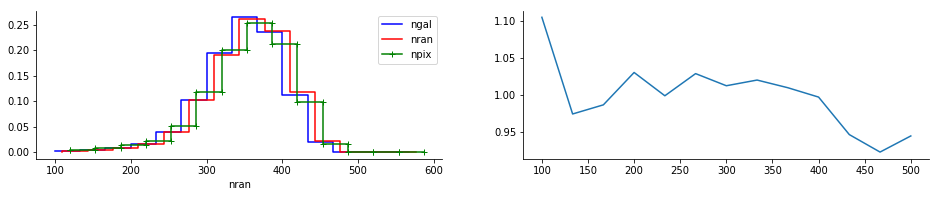

In [264]:
m=['','','+']
c = ['b', 'r', 'g']
l = ['ngal','nran', 'npix']
plt.figure(figsize=(16, 6))
plt.subplot(221)
for i, y_s in enumerate([ngal_i, nran_i, npix_i]):
    s = np.sum(y_s)
#     plt.subplot(421+i)
    plt.step(bins[:-1]+i*10, y_s/s, marker=m[i], color=c[i], label=l[i])
plt.legend()
plt.xlabel('nran')
plt.subplot(222)
s = np.sum(nran_i) / np.sum(ngal_i)
plt.plot(bins[:-1], ngal_i/nran_i * s)

In [262]:
fracgood = ranhp / (10000*hp.nside2pixarea(256, degrees=True))  # 10000 randoms per deg2

In [265]:
binsj, ngal_j, nran_j, npix_j = test_ngalnran(elghp, fracgood, bins = np.linspace(0.2, 1., 16))

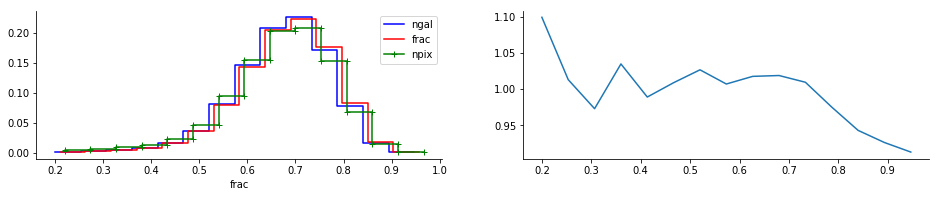

In [270]:
m=['','','+']
c = ['b', 'r', 'g']
l = ['ngal','frac', 'npix']
plt.figure(figsize=(16, 6))
plt.subplot(221)
for i, y_s in enumerate([ngal_j, nran_j, npix_j]):
    s = np.sum(y_s)
#     plt.subplot(421+i)
    plt.step(binsj[:-1]+i*0.01, y_s/s, marker=m[i], color=c[i], label=l[i])
plt.legend()
plt.xlabel('frac')
plt.subplot(222)
s = np.sum(nran_j) / np.sum(ngal_j)
plt.plot(binsj[:-1], ngal_j/nran_j * s)

In [271]:
bins_k, ngal_k, nran_k, npix_k = test_ngalnran(elghp/fracgood, fracgood, bins = np.linspace(0.2, 1., 16))

/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


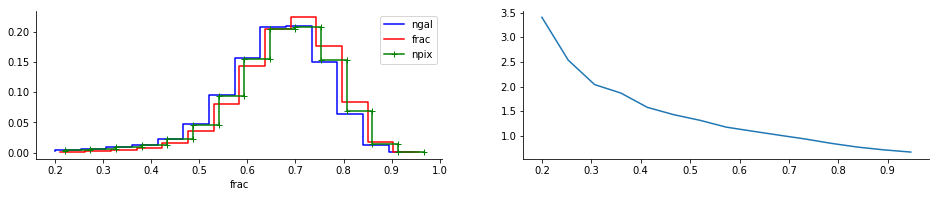

In [272]:
m=['','','+']
c = ['b', 'r', 'g']
l = ['ngal','frac', 'npix']
plt.figure(figsize=(16, 6))
plt.subplot(221)
for i, y_s in enumerate([ngal_k, nran_k, npix_k]):
    s = np.sum(y_s)
#     plt.subplot(421+i)
    plt.step(binsj[:-1]+i*0.01, y_s/s, marker=m[i], color=c[i], label=l[i])
plt.legend()
plt.xlabel('frac')
plt.subplot(222)
s = np.sum(nran_k) / np.sum(ngal_k)
plt.plot(bins_k[:-1], ngal_k/nran_k * s)

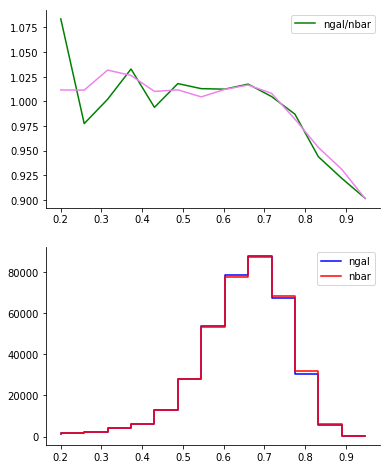

In [275]:
b = np.linspace(Xtrue[:,0].min(), Xtrue[:,0].max(), 15)
y1,_,_ = binned_statistic(Xtrue[:,0], values=Ytrue, bins=b, statistic='sum')       # sum of Ngal
yp,_,_ = binned_statistic(Xtrue[:,0], values=Ypred, bins=b, statistic='sum')       # sum of Npred
y2,_,_ = binned_statistic(Xtrue[:,0], values=np.ones(Xtrue[:,0].shape), bins=b, statistic='sum')  # sum of fracgood
sf = y2.sum()/y1.sum()
sf2 = y2.sum()/yp.sum()
plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(b[:-1], y1/y2*sf, 'g', label='ngal/nbar')
plt.legend()
plt.plot(b[:-1], yp/y2*sf2, 'violet')
# plt.ylim(0.7,1.2)
plt.subplot(212)
plt.step(b[:-1], y1, 'b', label='ngal')
plt.step(b[:-1], y2/sf, 'r', label='nbar')
plt.legend()

In [268]:
s

0.058896109823734846

In [219]:
import fitsio as ft

In [220]:
random_wo_anymask = ft.read('$SCRATCH/eboss/ebossv5_10_7/march12/eBOSS_ELG_full_ALL_vtest.ran.fits')

In [221]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
from syslss import hpixsum

In [225]:
ranmap_wo_anymask = hpixsum(256, random_wo_anymask['RA'], random_wo_anymask['DEC'])

(array([  463.,   323.,    60.,    99.,   129.,   224.,   432.,  1060.,
         1801.,  1937.,  2263.,  4070.,  7304.,  2894.,   137.]),
 array([   1. ,   41.4,   81.8,  122.2,  162.6,  203. ,  243.4,  283.8,
         324.2,  364.6,  405. ,  445.4,  485.8,  526.2,  566.6,  607. ]),
 <a list of 15 Patch objects>)

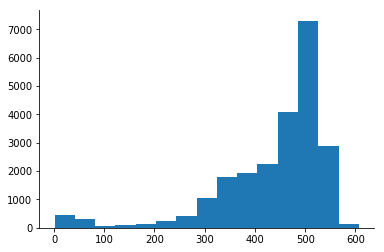

In [227]:
plt.hist(ranmap_wo_anymask[ranmap_wo_anymask!=0.0], bins=15)

[-3, 3, -3, 3]

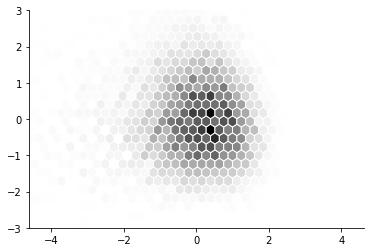

In [201]:
def normit(array):
    return (array - np.mean(array)) / np.std(array)
plt.hexbin(normit(Xtrue[:,0]), normit(Ytrue), gridsize=30,
           cmap=plt.cm.binary, edgecolors='white')
plt.axis('equal')
plt.axis([-3, 3, -3, 3])

In [202]:
from scipy.stats import pearsonr

In [203]:
pearsonr(Xtrue[:,0], Ytrue)

(-0.048033659913912757, 6.6784205316269698e-13)

In [278]:
ranmap1[ranmap1!=0.0].astype(np.bool)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)